---
# Final Solution: Stock Sentiment Classification with Transformers
---
This notebook implements the final text classification pipeline for predicting stock market sentiment from tweets. This solution uses a Transformer-based model (RoBERTa) trained on raw (not preprocessed) and tokenized tweets.

---
## Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
  )
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load train data
train_path = "/content/drive/MyDrive/Project Data/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# Load test data
test_path = "/content/drive/MyDrive/Project Data/test.csv"
#train_path = "Project Data-20250507/test.csv"
test_df = pd.read_csv(test_path)

# View shape and features of train_df
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# View shape and features of test_df
print("Test data shape:", test_df.shape)
print("\nTest data columns:", test_df.columns.tolist())

# Display first few rows of train data
print("\nFirst 5 rows of training data:")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (9543, 2)

Training data columns: ['text', 'label']
Test data shape: (2388, 2)

Test data columns: ['id', 'text']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


---
## Set the seed for reproducibulity
---

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

---
## Text Cleaning
---
Roberta was trained on unprocessed data, therefore no text cleaning is necassary.

---
## Data split into train and validation
---

After loading both sets, we split `train.csv` into 80% training and 20% validation sets while preserving class balance using stratified sampling.

In [4]:
# Train and val (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    train_df["text"], train_df["label"],
    test_size=0.2, stratify=train_df["label"], random_state=42
)

---
## Prepare hugging face DatasetDict
---
DatasetDict stores data splits in an accessible way for other Hugging Face's tools. This includes:
- Training data (with `text` and `label` columns)
- Validation data (with `text` and `label` columns)
- Test data (with `id` and `text` columns only)

In [5]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}),
    "validation": Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()}),
    "test": Dataset.from_dict({"id": test_df["id"].tolist(),"text": test_df["text"].tolist()})
})

---
## Use roberta tokenizer
---
We use the `roberta-base` tokenizer to tokenize tweet text. Padding and truncation are applied to fit within a maximum sequence length of 64 tokens.

In [6]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64)

tokenized = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [7]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7634
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1909
    })
    test: Dataset({
        features: ['id', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2388
    })
})

---
## Show an example of a tweet: original and tokenized
---

In [8]:
# Show one example from the training set
sample = tokenized["train"][0]

# Decode the input_ids back into readable text
decoded_text = tokenizer.decode(sample["input_ids"])

# Display nicely
print("Original Text:")
print(dataset["train"][0]["text"])
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])

Original Text:
Nasdaq prices 600M of 0.875% senior notes

Tokenized Input IDs:
[0, 487, 281, 5946, 850, 5594, 448, 9, 321, 4, 29271, 207, 949, 2775, 2]

Decoded (Recovered) Text:
<s>Nasdaq prices 600M of 0.875% senior notes</s>

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
2


---
## Print the longest tokenized example
---

In [9]:
# Find the longest tokenized example in the training set
longest_idx = max(
    range(len(tokenized["train"])),
    key=lambda i: sum(tokenized["train"][i]["attention_mask"])  # counts real tokens (ignores padding)
)

# Retrieve the sample
sample = tokenized["train"][longest_idx]

# Decode back into readable text
decoded_text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

# Display information
print("Index of Longest Tokenized Example:", longest_idx)
print("Original Text:")
print(dataset["train"][longest_idx]["text"])
print("\nNumber of Tokens (excluding padding):", sum(sample["attention_mask"]))
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])


Index of Longest Tokenized Example: 13
Original Text:
Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $ENR $EQM $ETRN $FE $HAS $HLX $JD $KIM $LYFT $NTR $NVDA $ORAN $PROS $SNAP $WEN $WING $WRI $ZS

Number of Tokens (excluding padding): 64

Tokenized Input IDs:
[0, 10926, 25579, 365, 73, 1244, 35, 68, 2747, 19839, 68, 347, 2562, 100, 68, 25388, 68, 495, 30438, 68, 495, 18307, 68, 2796, 500, 68, 717, 1864, 448, 68, 3935, 39151, 68, 10885, 68, 725, 2336, 68, 8064, 1000, 68, 26697, 68, 530, 3755, 68, 14079, 11615, 68, 487, 6997, 68, 31668, 3134, 68, 3411, 1889, 68, 4454, 3196, 68, 12436, 591, 2]

Decoded (Recovered) Text:
Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $ENR $EQM $ETRN $FE $HAS $HLX $JD $KIM $LYFT $NTR $NVDA $ORAN $PROS $SNAP

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
1


---
## Dynamic padding collator
---
Data collators are objects that will form a batch by using a list of dataset elements as input

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
## Compute metrics
---

In [11]:
def compute_metrics(eval_pred):
    """
    Custom metric function for Hugging Face Trainer.
    Assumes multi-class classification with labels 0, 1, 2.
    """
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


---
## Define Trainer subclass
---
We will define custom trainer to log train vs validation metrics. It was inspired by a solutiuon found on Hugging Face forum from user mbforbes. Link to the discussion: https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461/3

In [12]:
class EvalTrainCallback(TrainerCallback):
    """
    Custom callback that evaluates the model on both training and validation sets
    every `log_every_n_steps` steps during training.
    """

    def __init__(self, trainer, train_dataset, eval_dataset, log_every_n_steps=100):
        self.trainer = trainer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.log_every_n_steps = log_every_n_steps

        # Store metrics and steps for later plotting
        self.train_metrics = []
        self.eval_metrics = []
        self.steps = []

    def on_step_end(self, args, state, control, **kwargs):
        """Called at the end of each training step"""
        if state.global_step % self.log_every_n_steps != 0:
            return

        print(f"\nStep {state.global_step} - Evaluating on training and validation sets...")

        # Evaluate on the training set
        train_output = self.trainer.evaluate(eval_dataset=self.train_dataset)

        # Evaluate on the validation set
        eval_output = self.trainer.evaluate(eval_dataset=self.eval_dataset)

        # Save metrics from both sets
        self.train_metrics.append({
            'accuracy': train_output.get('eval_accuracy', 0),
            'f1': train_output.get('eval_f1', 0),
            'loss': train_output.get('eval_loss', 0)
        })

        self.eval_metrics.append({
            'accuracy': eval_output.get('eval_accuracy', 0),
            'f1': eval_output.get('eval_f1', 0),
            'loss': eval_output.get('eval_loss', 0)
        })

        self.steps.append(state.global_step)

        # Print summary
        print("=" * 60)
        print(f"Step {state.global_step} Results:")
        print(f"Train Accuracy: {train_output.get('eval_accuracy', 0):.4f} | Val Accuracy: {eval_output.get('eval_accuracy', 0):.4f}")
        print(f"Train F1: {train_output.get('eval_f1', 0):.4f} | Val F1: {eval_output.get('eval_f1', 0):.4f}")
        acc_gap = train_output.get('eval_accuracy', 0) - eval_output.get('eval_accuracy', 0)
        print(f"Accuracy Gap: {acc_gap:.4f}")
        print("Overfitting Status:", end=" ")

        # Interpret overfitting
        if acc_gap < 0.05:
            print("No overfitting")
        elif acc_gap < 0.10:
            print("Mild overfitting")
        else:
            print("Significant overfitting")
        print("=" * 60 + "\n")

---
## Training arguments
---

In [13]:
training_args = TrainingArguments(
    output_dir="./results/roberta_full",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_full",
    report_to="none",
    seed=24
)

---
## Load model and trainer
---

In [14]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Initialize the custom trainer
eval_callback = EvalTrainCallback(
    trainer=trainer,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    log_every_n_steps=100  # Log metrics every 100 steps
)

trainer.add_callback(eval_callback)

<ipython-input-15-3365713725>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


---
## Train the model and plot its metrics
---
We evaluate the model on the validation set using standard metrics such as:
- Accuracy
- Precision
- Recall
- F1-score

Visualizations comparing the train and validation metrics are printed below. These will be helpful to evaluate what is the optimal number of epochs to train the model for.

In [16]:
# Train the model
print("Starting training with train/val evaluation...")
trainer.train()

Starting training with train/val evaluation...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,No log,0.613623,0.747512,0.699085,0.660922,0.635121
200,No log,0.489077,0.838135,0.804816,0.760307,0.779569
300,No log,0.435651,0.836040,0.781280,0.818530,0.797052
400,No log,0.420109,0.850707,0.795406,0.828452,0.810353
500,No log,0.441342,0.843897,0.792696,0.825148,0.804755
600,No log,0.410940,0.855422,0.820785,0.827200,0.818923
700,No log,0.346006,0.874804,0.844310,0.832778,0.837567
800,No log,0.391580,0.872184,0.857669,0.808945,0.830712
900,No log,0.335017,0.874804,0.874670,0.796408,0.828599
1000,No log,0.504417,0.866946,0.814671,0.868252,0.837526



Step 100 - Evaluating on training and validation sets...
Step 100 Results:
Train Accuracy: 0.7426 | Val Accuracy: 0.7475
Train F1: 0.6326 | Val F1: 0.6351
Accuracy Gap: -0.0049
Overfitting Status: No overfitting


Step 200 - Evaluating on training and validation sets...
Step 200 Results:
Train Accuracy: 0.8424 | Val Accuracy: 0.8381
Train F1: 0.7865 | Val F1: 0.7796
Accuracy Gap: 0.0043
Overfitting Status: No overfitting


Step 300 - Evaluating on training and validation sets...
Step 300 Results:
Train Accuracy: 0.8411 | Val Accuracy: 0.8360
Train F1: 0.8009 | Val F1: 0.7971
Accuracy Gap: 0.0051
Overfitting Status: No overfitting


Step 400 - Evaluating on training and validation sets...
Step 400 Results:
Train Accuracy: 0.8631 | Val Accuracy: 0.8507
Train F1: 0.8253 | Val F1: 0.8104
Accuracy Gap: 0.0124
Overfitting Status: No overfitting


Step 500 - Evaluating on training and validation sets...
Step 500 Results:
Train Accuracy: 0.8697 | Val Accuracy: 0.8439
Train F1: 0.8342 | Val F1

TrainOutput(global_step=2865, training_loss=0.34435014708087913, metrics={'train_runtime': 1272.8471, 'train_samples_per_second': 17.993, 'train_steps_per_second': 2.251, 'total_flos': 554238136576152.0, 'train_loss': 0.34435014708087913, 'epoch': 3.0})

In [17]:
# Plotting function
def plot_training_curves(eval_callback):
    """Plot training and validation curves from EvalTrainCallback."""

    if not eval_callback.steps:
        print("No evaluation data to plot!")
        return

    steps = eval_callback.steps
    train_acc = [m['accuracy'] for m in eval_callback.train_metrics]
    val_acc = [m['accuracy'] for m in eval_callback.eval_metrics]
    train_f1 = [m['f1'] for m in eval_callback.train_metrics]
    val_f1 = [m['f1'] for m in eval_callback.eval_metrics]
    train_loss = [m['loss'] for m in eval_callback.train_metrics]
    val_loss = [m['loss'] for m in eval_callback.eval_metrics]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training vs Validation Metrics - Overfitting Analysis', fontsize=16)

    # Plot 1: Accuracy
    ax1 = axes[0, 0]
    ax1.plot(steps, train_acc, 'b-o', label='Train Accuracy', linewidth=2, markersize=8)
    ax1.plot(steps, val_acc, 'r-s', label='Val Accuracy', linewidth=2, markersize=8)
    ax1.fill_between(steps, train_acc, val_acc, alpha=0.3, color='gray')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy: Train vs Validation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: F1 Score
    ax2 = axes[0, 1]
    ax2.plot(steps, train_f1, 'b-o', label='Train F1', linewidth=2, markersize=8)
    ax2.plot(steps, val_f1, 'r-s', label='Val F1', linewidth=2, markersize=8)
    ax2.fill_between(steps, train_f1, val_f1, alpha=0.3, color='gray')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score: Train vs Validation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Loss
    ax3 = axes[1, 0]
    ax3.plot(steps, train_loss, 'g-o', label='Train Loss', linewidth=2, markersize=8)
    ax3.plot(steps, val_loss, 'm-s', label='Val Loss', linewidth=2, markersize=8)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss: Train vs Validation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Performance Gaps
    ax4 = axes[1, 1]
    acc_gap = [t - v for t, v in zip(train_acc, val_acc)]
    f1_gap = [t - v for t, v in zip(train_f1, val_f1)]

    ax4.plot(steps, acc_gap, 'b-o', label='Accuracy Gap', linewidth=2, markersize=8)
    ax4.plot(steps, f1_gap, 'r-s', label='F1 Gap', linewidth=2, markersize=8)
    ax4.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='5% threshold')
    ax4.axhline(y=0.10, color='red', linestyle='--', linewidth=2, label='10% threshold')
    ax4.fill_between(steps, 0, acc_gap, where=[g > 0.1 for g in acc_gap], color='red', alpha=0.3)
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Train - Val Gap')
    ax4.set_title('Overfitting Analysis: Accuracy & F1 Gaps')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary report
    print("\n" + "=" * 60)
    print("TRAINING SUMMARY")
    print("=" * 60)

    for i, step in enumerate(steps):
        print(f"\nStep {step}:")
        print(f"  Train: Acc={train_acc[i]:.4f}, F1={train_f1[i]:.4f}, Loss={train_loss[i]:.4f}")
        print(f"  Val:   Acc={val_acc[i]:.4f}, F1={val_f1[i]:.4f}, Loss={val_loss[i]:.4f}")
        print(f"  Gaps:  Acc={acc_gap[i]:.4f}, F1={f1_gap[i]:.4f}")

    best_val_f1_idx = val_f1.index(max(val_f1))
    print(f"\nBest Performance at Step {steps[best_val_f1_idx]} (Val F1: {max(val_f1):.4f})")

    # Heuristic: warn about last-step degradation or overfitting
    if len(steps) > 1:
        if val_acc[-1] < val_acc[-2] and val_f1[-1] < val_f1[-2]:
            print("\nRecommendation: Validation metrics dropped at last step. Consider earlier stopping.")
        elif acc_gap[-1] > 0.1:
            print("\nRecommendation: High overfitting at last step. Consider using fewer steps or regularization.")

    print("=" * 60)

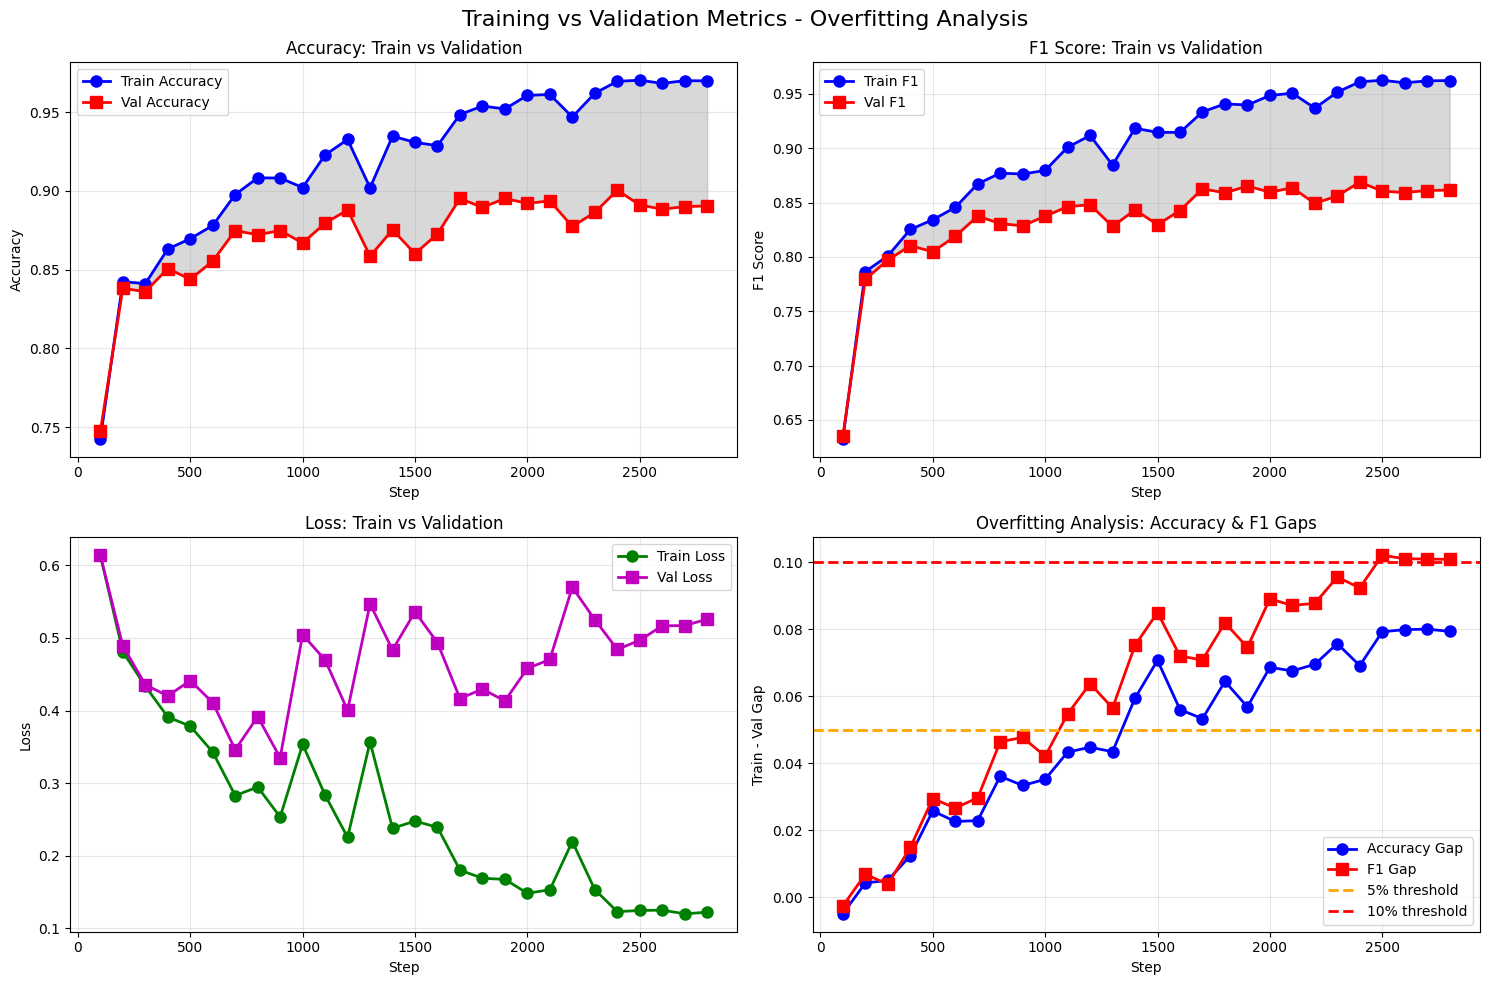


TRAINING SUMMARY

Step 100:
  Train: Acc=0.7426, F1=0.6326, Loss=0.6139
  Val:   Acc=0.7475, F1=0.6351, Loss=0.6136
  Gaps:  Acc=-0.0049, F1=-0.0026

Step 200:
  Train: Acc=0.8424, F1=0.7865, Loss=0.4808
  Val:   Acc=0.8381, F1=0.7796, Loss=0.4891
  Gaps:  Acc=0.0043, F1=0.0069

Step 300:
  Train: Acc=0.8411, F1=0.8009, Loss=0.4337
  Val:   Acc=0.8360, F1=0.7971, Loss=0.4357
  Gaps:  Acc=0.0051, F1=0.0039

Step 400:
  Train: Acc=0.8631, F1=0.8253, Loss=0.3911
  Val:   Acc=0.8507, F1=0.8104, Loss=0.4201
  Gaps:  Acc=0.0124, F1=0.0149

Step 500:
  Train: Acc=0.8697, F1=0.8342, Loss=0.3786
  Val:   Acc=0.8439, F1=0.8048, Loss=0.4413
  Gaps:  Acc=0.0258, F1=0.0295

Step 600:
  Train: Acc=0.8780, F1=0.8456, Loss=0.3428
  Val:   Acc=0.8554, F1=0.8189, Loss=0.4109
  Gaps:  Acc=0.0226, F1=0.0266

Step 700:
  Train: Acc=0.8977, F1=0.8673, Loss=0.2830
  Val:   Acc=0.8748, F1=0.8376, Loss=0.3460
  Gaps:  Acc=0.0229, F1=0.0297

Step 800:
  Train: Acc=0.9083, F1=0.8771, Loss=0.2946
  Val:   Acc=0.

In [23]:
# Plot the results
plot_training_curves(eval_callback)

---
## Train for optimal number of steps/epochs
---
The model is trained for 700 steps to avoid overfitting while still achieving solid performance.

In [19]:
training_args = TrainingArguments(
    output_dir="./results/roberta_final",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    max_steps=700,  # found optimal during analysis of plots printed above
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_final",
    report_to="none",
    seed=24
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-19-3973404496>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.198700


TrainOutput(global_step=700, training_loss=0.17710577283586776, metrics={'train_runtime': 115.5294, 'train_samples_per_second': 48.473, 'train_steps_per_second': 6.059, 'total_flos': 136465418563488.0, 'train_loss': 0.17710577283586776, 'epoch': 0.7329842931937173})

---
## Predict on the test set
---

In [20]:
# Predict on test
predictions = trainer.predict(tokenized["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)

# Check the shape of raw predictions (logits)
print("Shape of predictions.logits:", predictions.predictions.shape)
# Check the shape of final predicted labels
print("Shape of predicted labels:", pred_labels.shape)
# Compare against number of test samples
print("Number of test samples:", len(tokenized["test"]))
# Preview the first few predicted labels
print("First 10 predicted labels:", pred_labels[:10])

Shape of predictions.logits: (2388, 3)
Shape of predicted labels: (2388,)
Number of test samples: 2388
First 10 predicted labels: [1 2 2 1 2 1 0 0 2 2]


---
## Export the test labels
---
Exporting test set predictions according to delivery guide:

"A .csv file, named “pred_xx”, with only two columns - the id of the test set and your predicted labels for the test set."

In [21]:
# Save predictions as required
submission = pd.DataFrame({
    "id": dataset["test"]["id"],  # original test set IDs
    "label": pred_labels
})
submission.to_csv("pred_24.csv", index=False)

print("Submission file 'pred_24.csv' saved.")

Submission file 'pred_24.csv' saved.


---
## Evaluate the final model on validation set
---
We evaluate the model on the validation set using the following metrics:
- Accuracy
- Precision
- Recall
- F1-score

Additionally, we will print confusion matrix to evaluate per class performance of the model on validation set.


 Classification Report on Validation Set:

              precision    recall  f1-score   support

 Bearish (0)     0.7523    0.8646    0.8045       288
 Bullish (1)     0.8296    0.8597    0.8444       385
 Neutral (2)     0.9381    0.8948    0.9159      1236

    accuracy                         0.8832      1909
   macro avg     0.8400    0.8730    0.8550      1909
weighted avg     0.8882    0.8832    0.8847      1909



<Figure size 600x600 with 0 Axes>

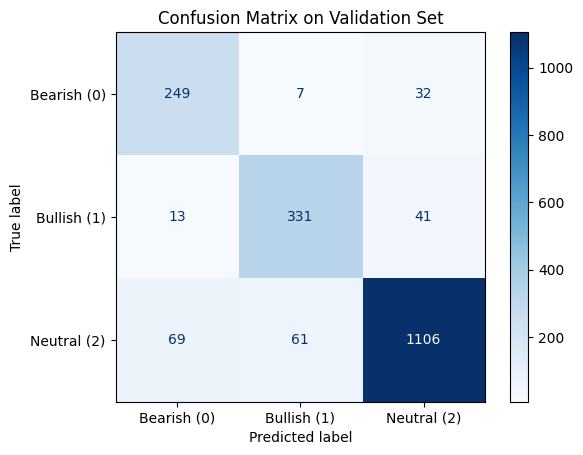

In [22]:
# Predict on validation set
preds = trainer.predict(tokenized["validation"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

# Print classification report
target_names = ["Bearish (0)", "Bullish (1)", "Neutral (2)"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("\n Classification Report on Validation Set:\n")
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Validation Set")
plt.show()